# The 2D heat equation

$$
\alpha^2 \left( \frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2}\right) = \frac{\partial u}{\partial t}
$$

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
class PINN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.net(x)

In [34]:
def initial_condition(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)


def boundary_condition(x, custom_value):
    return torch.full_like(x, custom_value)

In [35]:
def gerenate_training(num_points):
    x = torch.rand(num_points, 1, requires_grad=True)
    y = torch.rand(num_points, 1, requires_grad=True)
    t = torch.rand(num_points, 1, requires_grad=True)

    return x, y, t

In [36]:
def gerenate_boundary_points(num_points):
    x_boundary = torch.tensor([0.0, 1.0]).repeat(num_points // 2)
    y_boundary = torch.rand(num_points)

    if torch.rand(1) > 0.5:
        x_boundary, y_boundary = y_boundary, x_boundary

    return x_boundary.view(-1, 1), y_boundary.view(-1, 1)


def gerenate_boundary_training_data(num_points):
    x_boundary, y_boundary = gerenate_boundary_points(num_points)

    t = torch.rand(num_points, 1, requires_grad=True)

    return x_boundary, y_boundary, t

In [37]:
gerenate_training(2)

(tensor([[0.0645],
         [0.6188]], requires_grad=True),
 tensor([[0.6184],
         [0.9588]], requires_grad=True),
 tensor([[0.8634],
         [0.6286]], requires_grad=True))

In [38]:
gerenate_boundary_training_data(2)

(tensor([[0.],
         [1.]]),
 tensor([[0.9467],
         [0.5226]]),
 tensor([[0.8061],
         [0.0082]], requires_grad=True))

In [39]:
def pde(x, y, t, model):
    input_data = torch.cat([x, y, t], dim=1)

    u = model(input_data)

    du_dx, du_dy = torch.autograd.grad(
        u,
        [x, y],
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True,
    )

    du_dx_2 = torch.autograd.grad(
        du_dx,
        x,
        grad_outputs=torch.ones_like(du_dx),
        create_graph=True,
        retain_graph=True,
    )[0]

    du_dy_2 = torch.autograd.grad(
        du_dy,
        y,
        grad_outputs=torch.ones_like(du_dy),
        create_graph=True,
        retain_graph=True,
    )[0]

    du_dt = torch.autograd.grad(
        u,
        t,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True,
    )[0]

    heat_eq = 1 * (du_dx_2 + du_dy_2) - du_dt

    return heat_eq

In [40]:
def train_PINN(model, num_iterations, num_points):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for it in range(num_iterations):
        optimizer.zero_grad()

        x, y, t = gerenate_training(num_points)

        x_b, y_b, t_b = gerenate_boundary_training_data(num_points)

        t_initial = torch.zeros_like(t)
        u_initial = initial_condition(x, y)

        custom_value = 0

        u_boundary_x = boundary_condition(x_b, custom_value)
        u_boundary_y = boundary_condition(y_b, custom_value)

        u = pde(x, y, t, model)

        u_initial_pred = model(torch.cat([x, y, t_initial], dim=1))
        u_b_x_pred = model(torch.cat([x_b, y_b, t_b], dim=1))
        u_b_y_pred = model(torch.cat([y_b, x_b, t_b], dim=1))

        u_initial_loss = nn.MSELoss()(u_initial, u_initial_pred)

        u_b_x_loss = nn.MSELoss()(u_boundary_x, u_b_x_pred)

        u_b_y_loss = nn.MSELoss()(u_boundary_y, u_b_y_pred)

        u_loss = nn.MSELoss()(u, torch.zeros_like(u))

        loss = u_initial_loss + u_b_x_loss + u_b_y_loss + u_loss

        loss.backward()
        optimizer.step()

        if it % 100 == 0:
            print("Iteration ", it, ": loss ", loss.item())

In [41]:
model = PINN()

n_iterations = 10000

n_points = 1000

train_PINN(model, n_iterations, n_points)

Iteration  0 : loss  0.301825612783432
Iteration  100 : loss  0.12959088385105133
Iteration  200 : loss  0.12258625775575638
Iteration  300 : loss  0.1107381284236908
Iteration  400 : loss  0.09849411994218826
Iteration  500 : loss  0.07840235531330109
Iteration  600 : loss  0.06691404432058334
Iteration  700 : loss  0.05776413902640343
Iteration  800 : loss  0.05206625908613205
Iteration  900 : loss  0.045384302735328674
Iteration  1000 : loss  0.040818098932504654
Iteration  1100 : loss  0.03788226470351219
Iteration  1200 : loss  0.03593091294169426
Iteration  1300 : loss  0.03585067018866539
Iteration  1400 : loss  0.02693178318440914
Iteration  1500 : loss  0.025043372064828873
Iteration  1600 : loss  0.025996901094913483
Iteration  1700 : loss  0.02149040997028351
Iteration  1800 : loss  0.020818069577217102
Iteration  1900 : loss  0.018894024193286896
Iteration  2000 : loss  0.01852104254066944
Iteration  2100 : loss  0.01689842715859413
Iteration  2200 : loss  0.017785113304853

In [ ]:
for i in range(10000):
    with torch.no_grad():
        x_vals = torch.linspace(0, 1, 100)
        y_vals = torch.linspace(0, 1, 100)
        X, Y = torch.meshgrid(x_vals, y_vals)

        t_val = torch.ones_like(X) * i  # specify time

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

        solution = model(input_data).reshape(X.shape, Y.shape)

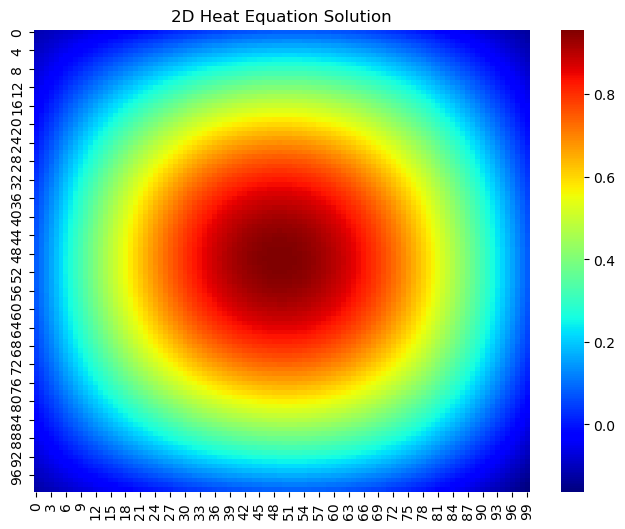

In [42]:
with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)

    t_val = torch.ones_like(X) * 0  # specify time

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

    solution = model(input_data).reshape(X.shape, Y.shape)

    plt.figure(figsize=(8, 6))
    sns.heatmap(solution, cmap="jet")
    plt.title("2D Heat Equation Solution")

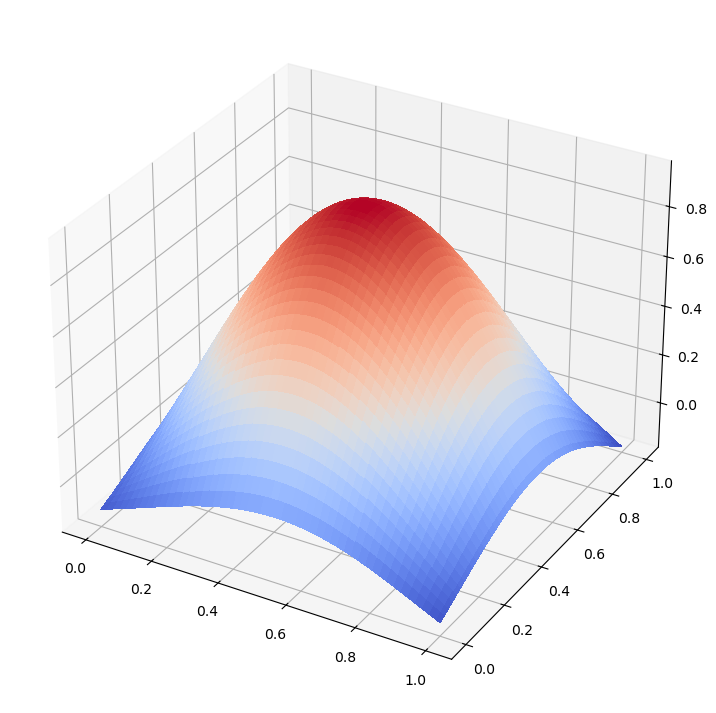

In [43]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fig.set_figwidth(16)
fig.set_figheight(9)

with torch.no_grad():
    x_vals = torch.linspace(0, 1, 100)
    y_vals = torch.linspace(0, 1, 100)
    X, Y = torch.meshgrid(x_vals, y_vals)

    t_val = torch.ones_like(X) * 0  # specify time

    input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

    solution = model(input_data).reshape(X.shape, Y.shape)

# Plot the surface.
surf = ax.plot_surface(
    X, Y, solution.T, cmap=cm.coolwarm, linewidth=0, antialiased=False
)


fig.xlabel = "x"
fig.ylabel = "time"
fig.zlabel = "temperature"

plt.show()

In [44]:
solution.shape

torch.Size([100, 100])

In [53]:
nt = len(t_val.flatten())
nt

10000

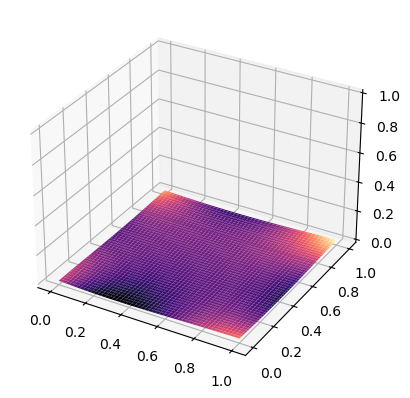

In [55]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

nt = 100
# nt = 5

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x_vals = torch.linspace(0, 1, 100)
y_vals = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_vals, y_vals)

zarray = np.zeros((len(x_vals), len(y_vals), nt))

with torch.no_grad():
    for i in range(nt):
        t_val = torch.ones_like(X) * i * 0.005  # specify time

        input_data = torch.stack([X.flatten(), Y.flatten(), t_val.flatten()], dim=1)

        solution = model(input_data).reshape(X.shape, Y.shape)

        zarray[:, :, i] = solution


# Plot the surface.
plot = [ax.plot_surface(X, Y, zarray[:, :, 0], color="0.75", rstride=1, cstride=1)]
ax.set_zlim(0, 1)


def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Y, zarray[:, :, frame_number], cmap="magma")


animate = animation.FuncAnimation(
    fig, update_plot, nt, interval=40, fargs=(zarray, plot)
)
# To save the animation, use e.g.
#
animate.save("pinn_2D_heat_surface.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()